In [4]:
import xgboost, pandas as pd
import duckdb as db 
from xgboost import plot_importance, plot_tree
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
from sklearn.metrics import mean_squared_log_error
import numpy as np 

def calculate_rmsle(y_true, y_pred):
    if (y_true < 0).any() or (y_pred < 0).any():
        raise ValueError("RMSLE cannot be computed when true or predicted values are negative.")
    
    # Calculate the Mean Squared Logarithmic Error (MSLE)
    msle = mean_squared_log_error(y_true, y_pred)
    
    # Calculate the Root Mean Squared Logarithmic Error (RMSLE)
    rmsle = np.sqrt(msle)
    
    return rmsle

In [6]:
df_train, df_holidays, df_stores, df_transactions, df_oil = pd.read_csv('train.csv'), pd.read_csv('holidays_events.csv'), pd.read_csv('stores.csv'), pd.read_csv('transactions.csv'), pd.read_csv('oil.csv')
#df_train['payday'] = df_train['date'].apply(lambda x: 1 if (pd.to_datetime(x).day==15 or pd.to_datetime(x).is_month_end) else 0)
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [7]:
df_final_hols_count = db.sql("""
with cte as (
  select * , month(date::datetime) "month", year(date::datetime) "year", week(date::datetime) "week" from df_holidays
) , hols_count as (
select distinct year, week, count(type) OVER (partition by year, week ORDER BY week ASC) "number_of_holidays" from cte 
), final_hols_count as (
select  distinct year, week, avg(number_of_holidays ) OVER (PARTITION BY year, week) "number_of_holidays" FROM hols_count 
) 
select * from final_hols_count
""").df()
df_final_hols_count


,year,week,number_of_holidays
0,2013,46,2.0
1,2014,14,1.0
2,2017,16,1.0
3,2014,50,1.0
4,2016,20,1.0
...,...,...,...
153,2012,19,1.0
154,2016,52,2.0
155,2012,45,4.0
156,2017,13,1.0


In [8]:
df_transactions = pd.read_csv('transactions.csv')
df_transactions = db.sql("""
    select *, avg(transactions) OVER (partition by store_nbr order by date ROWS BETWEEN 8 PRECEDING AND 1 PRECEDING) "7d_transactions_avg" from df_transactions 
""").to_df()
df_transactions

,date,store_nbr,transactions,7d_transactions_avg
0,2013-01-02,7,1874,NaN
1,2013-01-03,7,1568,1874.000000
2,2013-01-04,7,1513,1721.000000
3,2013-01-05,7,1599,1651.666667
4,2013-01-06,7,1431,1638.500000
...,...,...,...,...
83483,2014-12-22,49,5302,4128.750000
83484,2014-12-23,49,5757,4260.875000
83485,2014-12-24,49,5844,4539.750000
83486,2014-12-26,49,3914,4815.625000


In [9]:
df_oil = pd.read_csv('oil.csv')
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil.set_index('date', inplace=True)
# Create a date range that covers the entire period of the dataset
date_range = pd.date_range(start=df_oil.index.min(), end=df_oil.index.max(), freq='D')
df_oil = df_oil.reindex(date_range, method='ffill')
df_oil['dcoilwtico'].bfill(inplace=True)
df_oil.reset_index(inplace=True)
df_oil.rename(columns={'index':'date'}, inplace=True)
df_oil = db.sql("""
    select *, avg(dcoilwtico) OVER (ORDER BY date ROWS BETWEEN 8 PRECEDING AND 1 PRECEDING) "7d_avg_oil_price"
    , avg(dcoilwtico) OVER (ORDER BY date ROWS BETWEEN 91 PRECEDING AND 1 PRECEDING) "90d_avg_oil_price" 
    from df_oil 
""").df().fillna(0)
df_oil

,date,dcoilwtico,7d_avg_oil_price,90d_avg_oil_price
0,2013-01-01,93.14,0.000000,0.000000
1,2013-01-02,93.14,93.140000,93.140000
2,2013-01-03,92.97,93.140000,93.140000
3,2013-01-04,93.12,93.083333,93.083333
4,2013-01-05,93.12,93.092500,93.092500
...,...,...,...,...
1699,2017-08-27,47.65,47.901250,46.751429
1700,2017-08-28,46.40,47.783750,46.730220
1701,2017-08-29,46.46,47.510000,46.694725
1702,2017-08-30,45.96,47.393750,46.659890


In [10]:
import duckdb as db, pandas as pd 
df_train = pd.read_csv('train.csv')
df_train = df_train.sort_values(['id'])
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year
df_train['day_of_week'] = df_train['date'].dt.day_of_week
df_train['day_of_month'] = df_train['date'].dt.day
df_train["quarter"] = df_train['date'].dt.quarter
df_train["weekofyear"] = df_train['date'].dt.isocalendar().week 
df_train['payday'] = df_train['date'].apply(lambda x: 1 if (pd.to_datetime(x).day==15 or pd.to_datetime(x).is_month_end) else 0)
df_train["is_weekend"] = df_train['day_of_week'].apply(lambda x: 1 if (x in (4,5,6)) else 0) 
#df_train['day_name'] = df_train['date'].dt.day_name()
df_train = db.sql("""   
    select distinct df_train.*  exclude sales
    , case when (h.type='Event' and description like 'Terremoto Manabi%' and family='BEVERAGES') then 3115
      when (h.type='Event' and description like 'Terremoto Manabi%' and family='GROCERY I') then 4325 
      when (h.type='Event' and description like 'Terremoto Manabi%' and family='CLEANING') then 1150 
      else sales 
      end "sales"  
    , s.cluster , s.type, s.state , s.city 
    , case when h.transferred='False' THEN  COALESCE(h.type, 'Work Day') ELSE 'Work Day' END "holiday_type"
    , o.dcoilwtico "oil_price",    "7d_avg_oil_price",	"90d_avg_oil_price"
    , t."7d_transactions_avg"
    , "number_of_holidays" 
    , case when h.locale = 'National' THEN 1 ELSE 0 END "is_national_holiday" 
    , case when (h.type='Event' and description like 'Terremoto Manabi%') THEN '1' ELSE 0 END "earthquake_impact"    
    from df_train 
    left join df_transactions t on df_train.date = t.date and df_train.store_nbr = t.store_nbr
    left join df_holidays h on h.date = df_train.date
    left join df_final_hols_count on df_train.weekofyear = df_final_hols_count.week and df_train.year=df_final_hols_count.year
    left join df_oil o on o.date = df_train.date                
    left join df_stores s on s.store_nbr = df_train.store_nbr 
    order by id 
""").df()
#df_train['oil_price'] = df_train['oil_price'].ffill()
#df_train['oil_price'] = df_train['oil_price'].bfill()
df_train["onpromotion"] = df_train["onpromotion"].astype(np.int32)
df_train['oil_price'] = df_train['oil_price'].astype(np.float32) 
df_train['sales'] = df_train['sales'].astype(np.float32) 
df_train['year']= df_train['year'].astype(np.int32)
df_train['month']= df_train['month'].astype(np.int32)
df_train['day_of_week']= df_train['day_of_week'].astype(np.int16)
df_train['day_of_month'] = df_train['day_of_month'].astype(np.int16)
df_train['weekofyear']= df_train['weekofyear'].astype(np.int16)
df_train["family"] = df_train["family"].astype('category')
df_train["onpromotion"] = df_train["onpromotion"].astype('category')
df_train["type"] = df_train["type"].astype('category')
df_train["cluster"] = df_train["cluster"].astype('category')
df_train["holiday_type"] = df_train["holiday_type"].astype('category')
df_train["is_holiday"] = df_train["holiday_type"].apply(lambda x: 1 if x=='Holiday' else 0)
df_train["store_nbr"] = df_train["store_nbr"].astype('category')
df_train["city"] = df_train["city"].astype('category')
df_train["is_weekend"] = df_train["is_weekend"].astype('category')
df_train.head(5)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,id,date,store_nbr,family,onpromotion,month,year,day_of_week,day_of_month,quarter,...,city,holiday_type,oil_price,7d_avg_oil_price,90d_avg_oil_price,7d_transactions_avg,number_of_holidays,is_national_holiday,earthquake_impact,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0,1,2013,1,1,1,...,Quito,Holiday,93.139999,0.0,0.0,NaN,3.0,1,0,1
1,1,2013-01-01,1,BABY CARE,0,1,2013,1,1,1,...,Quito,Holiday,93.139999,0.0,0.0,NaN,3.0,1,0,1
2,2,2013-01-01,1,BEAUTY,0,1,2013,1,1,1,...,Quito,Holiday,93.139999,0.0,0.0,NaN,3.0,1,0,1
3,3,2013-01-01,1,BEVERAGES,0,1,2013,1,1,1,...,Quito,Holiday,93.139999,0.0,0.0,NaN,3.0,1,0,1
4,4,2013-01-01,1,BOOKS,0,1,2013,1,1,1,...,Quito,Holiday,93.139999,0.0,0.0,NaN,3.0,1,0,1


ROLLING AVG TRENDS - weekly 

In [11]:
df_train = db.sql("""
    with cte as (
    select *
    , avg(sales) OVER (PARTITION BY store_nbr, family, day_of_week ORDER BY "date" ASC ROWS BETWEEN 4 PRECEDING AND 1 PRECEDING) AS "W3_rolling_mean_sales_store_family_dayofweek"
from df_train 
    ) 
    select * 
    from cte -- where store_nbr==1 and family=='BEVERAGES'
""").df()#.to_clipboard()
df_train = db.sql("""
    select *
    , avg(sales) OVER (PARTITION BY store_nbr, family ORDER BY "date" ASC ROWS BETWEEN 8 PRECEDING AND 1 PRECEDING) "7D_rolling_mean_sales_store_family"
from df_train     
""").df()

In [12]:
# df_train = db.sql("""
#  select * 
#     , lag(W3_rolling_mean_sales_store_family_dayofweek, 365) OVER(PARTITION BY store_nbr, family ORDER BY day_of_week) "lag_W3_rolling_mean_sales_store_family_dayofweek"
#  from df_train --where store_nbr==1 and family=='BEVERAGES'
#  """).df()#.to_clipboard()

In [13]:
df_avg_sales_by_month_store_fam = db.sql("""
    select store_nbr, family, year, month, avg(sales) "avg_sales"
    from df_train    
    --where store_nbr==1 and family=='BEVERAGES'
    group by store_nbr, family, year, month 
     order by store_nbr, month, year
""").df()

In [14]:
df_avg_sales_by_month_store_fam = db.sql("""
    with cte as (select t.id, a.avg_sales from df_train t left join df_avg_sales_by_month_store_fam a on a.store_nbr = t.store_nbr and a.family=t.family and a.year=t.year and a.month=t.month)
    , cte2 as (select t.id, a.avg_sales "avg_monthly_sales_year_minus1" from df_train t left join df_avg_sales_by_month_store_fam a on a.store_nbr = t.store_nbr and a.family=t.family and a.year=t.year-1 and a.month=t.month)
    , cte3 as (select t.id, a.avg_sales "avg_monthly_sales_year_minus2" from df_train t left join df_avg_sales_by_month_store_fam a on a.store_nbr = t.store_nbr and a.family=t.family and a.year=t.year-2 and a.month=t.month)
    select cte.*
    , coalesce(cte2.avg_monthly_sales_year_minus1,0) "avg_monthly_sales_year_minus1" 
    , coalesce(cte3.avg_monthly_sales_year_minus2,0) "avg_monthly_sales_year_minus2" 
    from cte join cte2 on cte.id=cte2.id  
    join cte3 on cte.id=cte3.id 
    --where store_nbr==1 and family=='BEVERAGES'
""").df()#.to_clipboard()


In [15]:
# df_avg_sales_by_week_store_fam = db.sql("""
#     select id, store_nbr, family, year, weekofyear, avg(sales) "weekly_avg_sales"
#     from df_train    
#     where year>=2015 --and store_nbr==1 and family=='BEVERAGES'
#     group by id, store_nbr, family, year, weekofyear 
#      order by id, store_nbr, year, weekofyear
# """).df()
# df_avg_sales_by_week_store_fam = db.sql("""
#     with cte as (select t.id, a.weekly_avg_sales::int32, t.store_nbr, t.family from df_train t join df_avg_sales_by_week_store_fam a on a.store_nbr = t.store_nbr and a.family=t.family and a.year=t.year and a.weekofyear=t.weekofyear)
#     , cte2 as (select t.id, a.weekly_avg_sales::int32 "avg_weekly_sales_year_minus1" from df_train t  join df_avg_sales_by_week_store_fam a on a.store_nbr = t.store_nbr and a.family=t.family and a.year=t.year-1 and a.weekofyear=t.weekofyear)
#     , cte3 as (select t.id, a.weekly_avg_sales::int32 "avg_weekly_sales_year_minus2" from df_train t  join df_avg_sales_by_week_store_fam a on a.store_nbr = t.store_nbr and a.family=t.family and a.year=t.year-2 and a.weekofyear=t.weekofyear)
#     select cte.id
#     , coalesce(cte2.avg_weekly_sales_year_minus1,0) "avg_weekly_sales_year_minus1" 
#     , coalesce(cte3.avg_weekly_sales_year_minus2,0) "avg_weekly_sales_year_minus2" 
#     from cte 
#     left join cte2 on cte.id=cte2.id  
#     left join cte3 on cte.id=cte3.id 
#     --where store_nbr==1 and family=='BEVERAGES'     
# """).df()#.to_clipboard()

In [16]:
df_train = db.sql("""
    select t.*, f.* exclude id from df_train t 
    left join df_avg_sales_by_month_store_fam f on f.id=t.id
    --left join df_avg_sales_by_week_store_fam f2 on f2.id=t.id 
""").df()

In [17]:
df_seasonality =db.sql("""
    with base as (
       select family, year, weekofyear, sum(sales) OVER (PARTITION BY family, year, weekofyear) "sales_qtrly" from df_train 
       where date < '2017-07-01' --and weekofyear <> 53 
    ), pivt as (
    PIVOT base
    ON year
    USING avg(sales_qtrly)    
    )
    select * from pivt 
""").df().sort_values(['weekofyear']) #.query("store_nbr== 1 and family=='EGGS'")
df_seasonality.loc[:,'Row_Total'] = df_seasonality[['2013','2014','2015','2016']].sum(numeric_only=True, axis=1)/4
mean_mean_factor = np.mean(df_seasonality["Row_Total"])
df_seasonality["scaled_seasonal_factor_weekly"] = df_seasonality["Row_Total"].apply(lambda x: x/mean_mean_factor)
df_train = db.sql("""
    select t.*, dfs.scaled_seasonal_factor_weekly from df_train t 
    join df_seasonality dfs on t.family=dfs.family and t.weekofyear = dfs.weekofyear     
""").df()#.query("store_nbr==1 and family=='EGGS'")#.to_clipboard()
df_train

,id,date,store_nbr,family,onpromotion,month,year,day_of_week,day_of_month,quarter,...,number_of_holidays,is_national_holiday,earthquake_impact,is_holiday,W3_rolling_mean_sales_store_family_dayofweek,7D_rolling_mean_sales_store_family,avg_sales,avg_monthly_sales_year_minus1,avg_monthly_sales_year_minus2,scaled_seasonal_factor_weekly
0,177743,2013-04-10,46,BREAD/BAKERY,0,4,2013,2,10,2,...,2.0,0,0,0,397.704506,551.525757,546.377239,0.000000,0.0,1.055970
1,179525,2013-04-11,46,BREAD/BAKERY,0,4,2013,3,11,2,...,2.0,0,0,0,370.757004,544.431381,546.377239,0.000000,0.0,1.055970
2,181307,2013-04-12,46,BREAD/BAKERY,0,4,2013,4,12,2,...,2.0,0,0,1,430.391251,531.515007,546.377239,0.000000,0.0,1.055970
3,183089,2013-04-13,46,BREAD/BAKERY,0,4,2013,5,13,2,...,2.0,0,0,0,769.347488,525.853382,546.377239,0.000000,0.0,1.055970
4,184871,2013-04-14,46,BREAD/BAKERY,0,4,2013,6,14,2,...,2.0,0,0,1,965.854004,556.349258,546.377239,0.000000,0.0,1.055970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401833,1112977,2014-09-18,37,LADIESWEAR,0,9,2014,3,18,3,...,NaN,0,0,0,13.250000,28.000000,31.333333,0.000000,0.0,0.023172
3401834,1114759,2014-09-19,37,LADIESWEAR,0,9,2014,4,19,3,...,NaN,0,0,0,11.250000,27.375000,31.333333,0.000000,0.0,0.023172
3401835,1116541,2014-09-20,37,LADIESWEAR,0,9,2014,5,20,3,...,NaN,0,0,0,29.750000,27.625000,31.333333,0.000000,0.0,0.023172
3401836,1118323,2014-09-21,37,LADIESWEAR,0,9,2014,6,21,3,...,NaN,0,0,0,21.500000,31.625000,31.333333,0.000000,0.0,0.023172


MODEL CREATION

In [18]:
#df_train = None
#df_train = pd.read_parquet('df_train')
pjme_test = df_train.query("year==2017 and (month>=8)")
pjme_train = df_train.drop(index=pjme_test.index)
pjme_train = pjme_train.drop(index=pjme_train.query("year==2017 and weekofyear==52").index)
pjme_train

,id,date,store_nbr,family,onpromotion,month,year,day_of_week,day_of_month,quarter,...,number_of_holidays,is_national_holiday,earthquake_impact,is_holiday,W3_rolling_mean_sales_store_family_dayofweek,7D_rolling_mean_sales_store_family,avg_sales,avg_monthly_sales_year_minus1,avg_monthly_sales_year_minus2,scaled_seasonal_factor_weekly
0,177743,2013-04-10,46,BREAD/BAKERY,0,4,2013,2,10,2,...,2.0,0,0,0,397.704506,551.525757,546.377239,0.000000,0.0,1.055970
1,179525,2013-04-11,46,BREAD/BAKERY,0,4,2013,3,11,2,...,2.0,0,0,0,370.757004,544.431381,546.377239,0.000000,0.0,1.055970
2,181307,2013-04-12,46,BREAD/BAKERY,0,4,2013,4,12,2,...,2.0,0,0,1,430.391251,531.515007,546.377239,0.000000,0.0,1.055970
3,183089,2013-04-13,46,BREAD/BAKERY,0,4,2013,5,13,2,...,2.0,0,0,0,769.347488,525.853382,546.377239,0.000000,0.0,1.055970
4,184871,2013-04-14,46,BREAD/BAKERY,0,4,2013,6,14,2,...,2.0,0,0,1,965.854004,556.349258,546.377239,0.000000,0.0,1.055970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401833,1112977,2014-09-18,37,LADIESWEAR,0,9,2014,3,18,3,...,NaN,0,0,0,13.250000,28.000000,31.333333,0.000000,0.0,0.023172
3401834,1114759,2014-09-19,37,LADIESWEAR,0,9,2014,4,19,3,...,NaN,0,0,0,11.250000,27.375000,31.333333,0.000000,0.0,0.023172
3401835,1116541,2014-09-20,37,LADIESWEAR,0,9,2014,5,20,3,...,NaN,0,0,0,29.750000,27.625000,31.333333,0.000000,0.0,0.023172
3401836,1118323,2014-09-21,37,LADIESWEAR,0,9,2014,6,21,3,...,NaN,0,0,0,21.500000,31.625000,31.333333,0.000000,0.0,0.023172


In [26]:
features = [ #'store_nbr', 
             'onpromotion' , 'family'
            #, 'day_of_week'           
            , 'W3_rolling_mean_sales_store_family_dayofweek'
            , '7D_rolling_mean_sales_store_family'             
            , "7d_avg_oil_price", "90d_avg_oil_price" , "scaled_seasonal_factor_weekly" 
            #, "lag_W3_rolling_mean_sales_store_family_dayofweek"   
            #, "avg_sales"
            ,	"avg_monthly_sales_year_minus1"	,"avg_monthly_sales_year_minus2"     
]

X_train, y_train = pjme_train[features], pjme_train['sales']
X_test, y_test = pjme_test[features], pjme_test['sales']
import sklearn.metrics
reg = XGBRegressor(n_estimators=20000, enable_categorical=True, early_stopping_rounds=15, eval_metric = 'rmsle', learning_rate = .3)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
pjme_test['prediction_label'] = reg.predict(X_test) 
pjme_test['prediction_label'] = pjme_test['prediction_label'].apply(lambda x: 0 if x<0 else x)
#pjme_test

[0]	validation_0-rmsle:3.57492	validation_1-rmsle:2.97714
[1]	validation_0-rmsle:3.19638	validation_1-rmsle:2.62089
[2]	validation_0-rmsle:2.83627	validation_1-rmsle:2.28668
[3]	validation_0-rmsle:nan	validation_1-rmsle:1.97332
[4]	validation_0-rmsle:nan	validation_1-rmsle:1.68729
[5]	validation_0-rmsle:nan	validation_1-rmsle:1.42303
[6]	validation_0-rmsle:nan	validation_1-rmsle:1.19682
[7]	validation_0-rmsle:nan	validation_1-rmsle:1.01020
[8]	validation_0-rmsle:nan	validation_1-rmsle:0.85705
[9]	validation_0-rmsle:nan	validation_1-rmsle:0.78333
[10]	validation_0-rmsle:nan	validation_1-rmsle:0.71929
[11]	validation_0-rmsle:nan	validation_1-rmsle:0.67098
[12]	validation_0-rmsle:nan	validation_1-rmsle:0.66212
[13]	validation_0-rmsle:nan	validation_1-rmsle:0.62244
[14]	validation_0-rmsle:nan	validation_1-rmsle:0.61132
[15]	validation_0-rmsle:nan	validation_1-rmsle:0.59326
[16]	validation_0-rmsle:nan	validation_1-rmsle:0.59231
[17]	validation_0-rmsle:nan	validation_1-rmsle:0.57930
[18]	val

C:\Users\vvvijaya\AppData\Local\Temp\ipykernel_3732\1926161283.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['prediction_label'] = reg.predict(X_test)
C:\Users\vvvijaya\AppData\Local\Temp\ipykernel_3732\1926161283.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['prediction_label'] = pjme_test['prediction_label'].apply(lambda x: 0 if x<0 else x)


In [27]:
display(calculate_rmsle(pjme_test['sales'] , pjme_test['prediction_label']))


0.4669691560046729

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

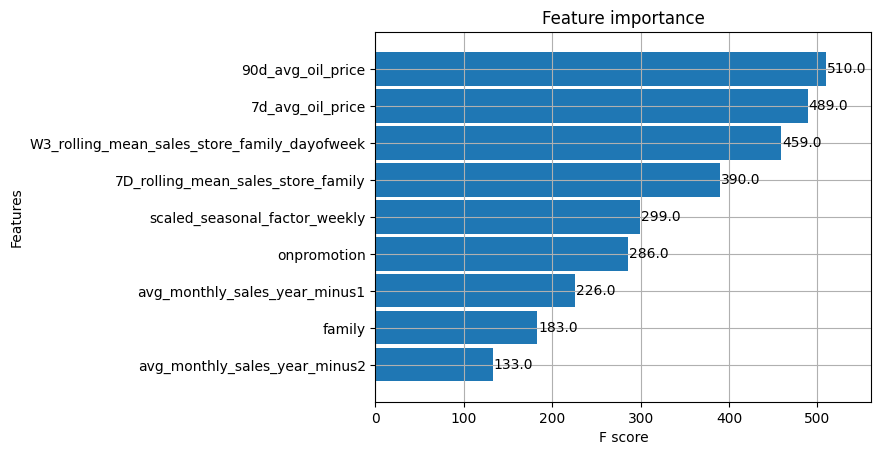

In [28]:
display(plot_importance(reg, height=0.9))

NEXT IDEAS:
1. 2 cols for lags of 3Wlagged_mean_sales_store_family_dayofweek - did not work as it goes back 1 week 
2. 2 cols for lags of 7D_rolling_mean_sales_store_family (previous two values) - done. 
3. 2 cols for lags of 7d_avg_oil_price - no impact i think. 
4. weekly or monthly rolling averages? 

In [30]:
pjme_test[['store_nbr','family','weekofyear','day_of_week','sales','prediction_label']].to_clipboard()

In [132]:
#pjme_train.to_parquet("pjme_train")

In [29]:
#pjme_test.query("family=='BEVERAGES' and date>='2017-06-01'")[['date','store_nbr','family','sales','prediction_label']].to_clipboard()

In [141]:
#pjme_train.query("family=='BEVERAGES' and store_nbr==44")[['date','store_nbr','family','sales',"avg_sales_year_minus1"	,"avg_sales_year_minus2"]].to_clipboard()

LGBM Model


In [25]:
# import lightgbm as lgb 

# param = { "metric": "rmse"}

# lgb.train(param, pjme_train, )